<a href="https://colab.research.google.com/github/MurrelSaldanha/Antibio-resistance/blob/main/Antibiotic_resistance_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying potential antibiotic resistance genes in *Neisseria gonorrhoeae*

## Introduction

*Neisseria gonorrhoeae* is a species of Gram-negative diplococci bacteria and the causative agent of the sexually transmitted infection Gonorrhoeae. Gonorrhoea is the second most common sexually transmitted infection (STI) in Europe, after chlamydia. Rates of gonorrhoea infection are on the rise, with a 26% increase reported from 2017-2018 in the UK.

Many people who are infected (especially women) experience no symptoms, helping its spread. However if the infection is left untreated, it can lead to infertility in women, and can occasionally spread to other parts of the body such as your joints, heart valves, brain or spinal cord.

Antimicrobial resistance is becoming a serious concern— currently antimicrobial resistant infections kill over 700,000 people per year. By 2050 its estimated 10 million people will die from of antimicrobial resistant infections. 

(Whittles, L. K., White, P. J., Paul, J., & Didelot, X. (2018). Epidemiological trends of antibiotic resistant gonorrhoea in the United Kingdom. Antibiotics, 7(3), 60.)

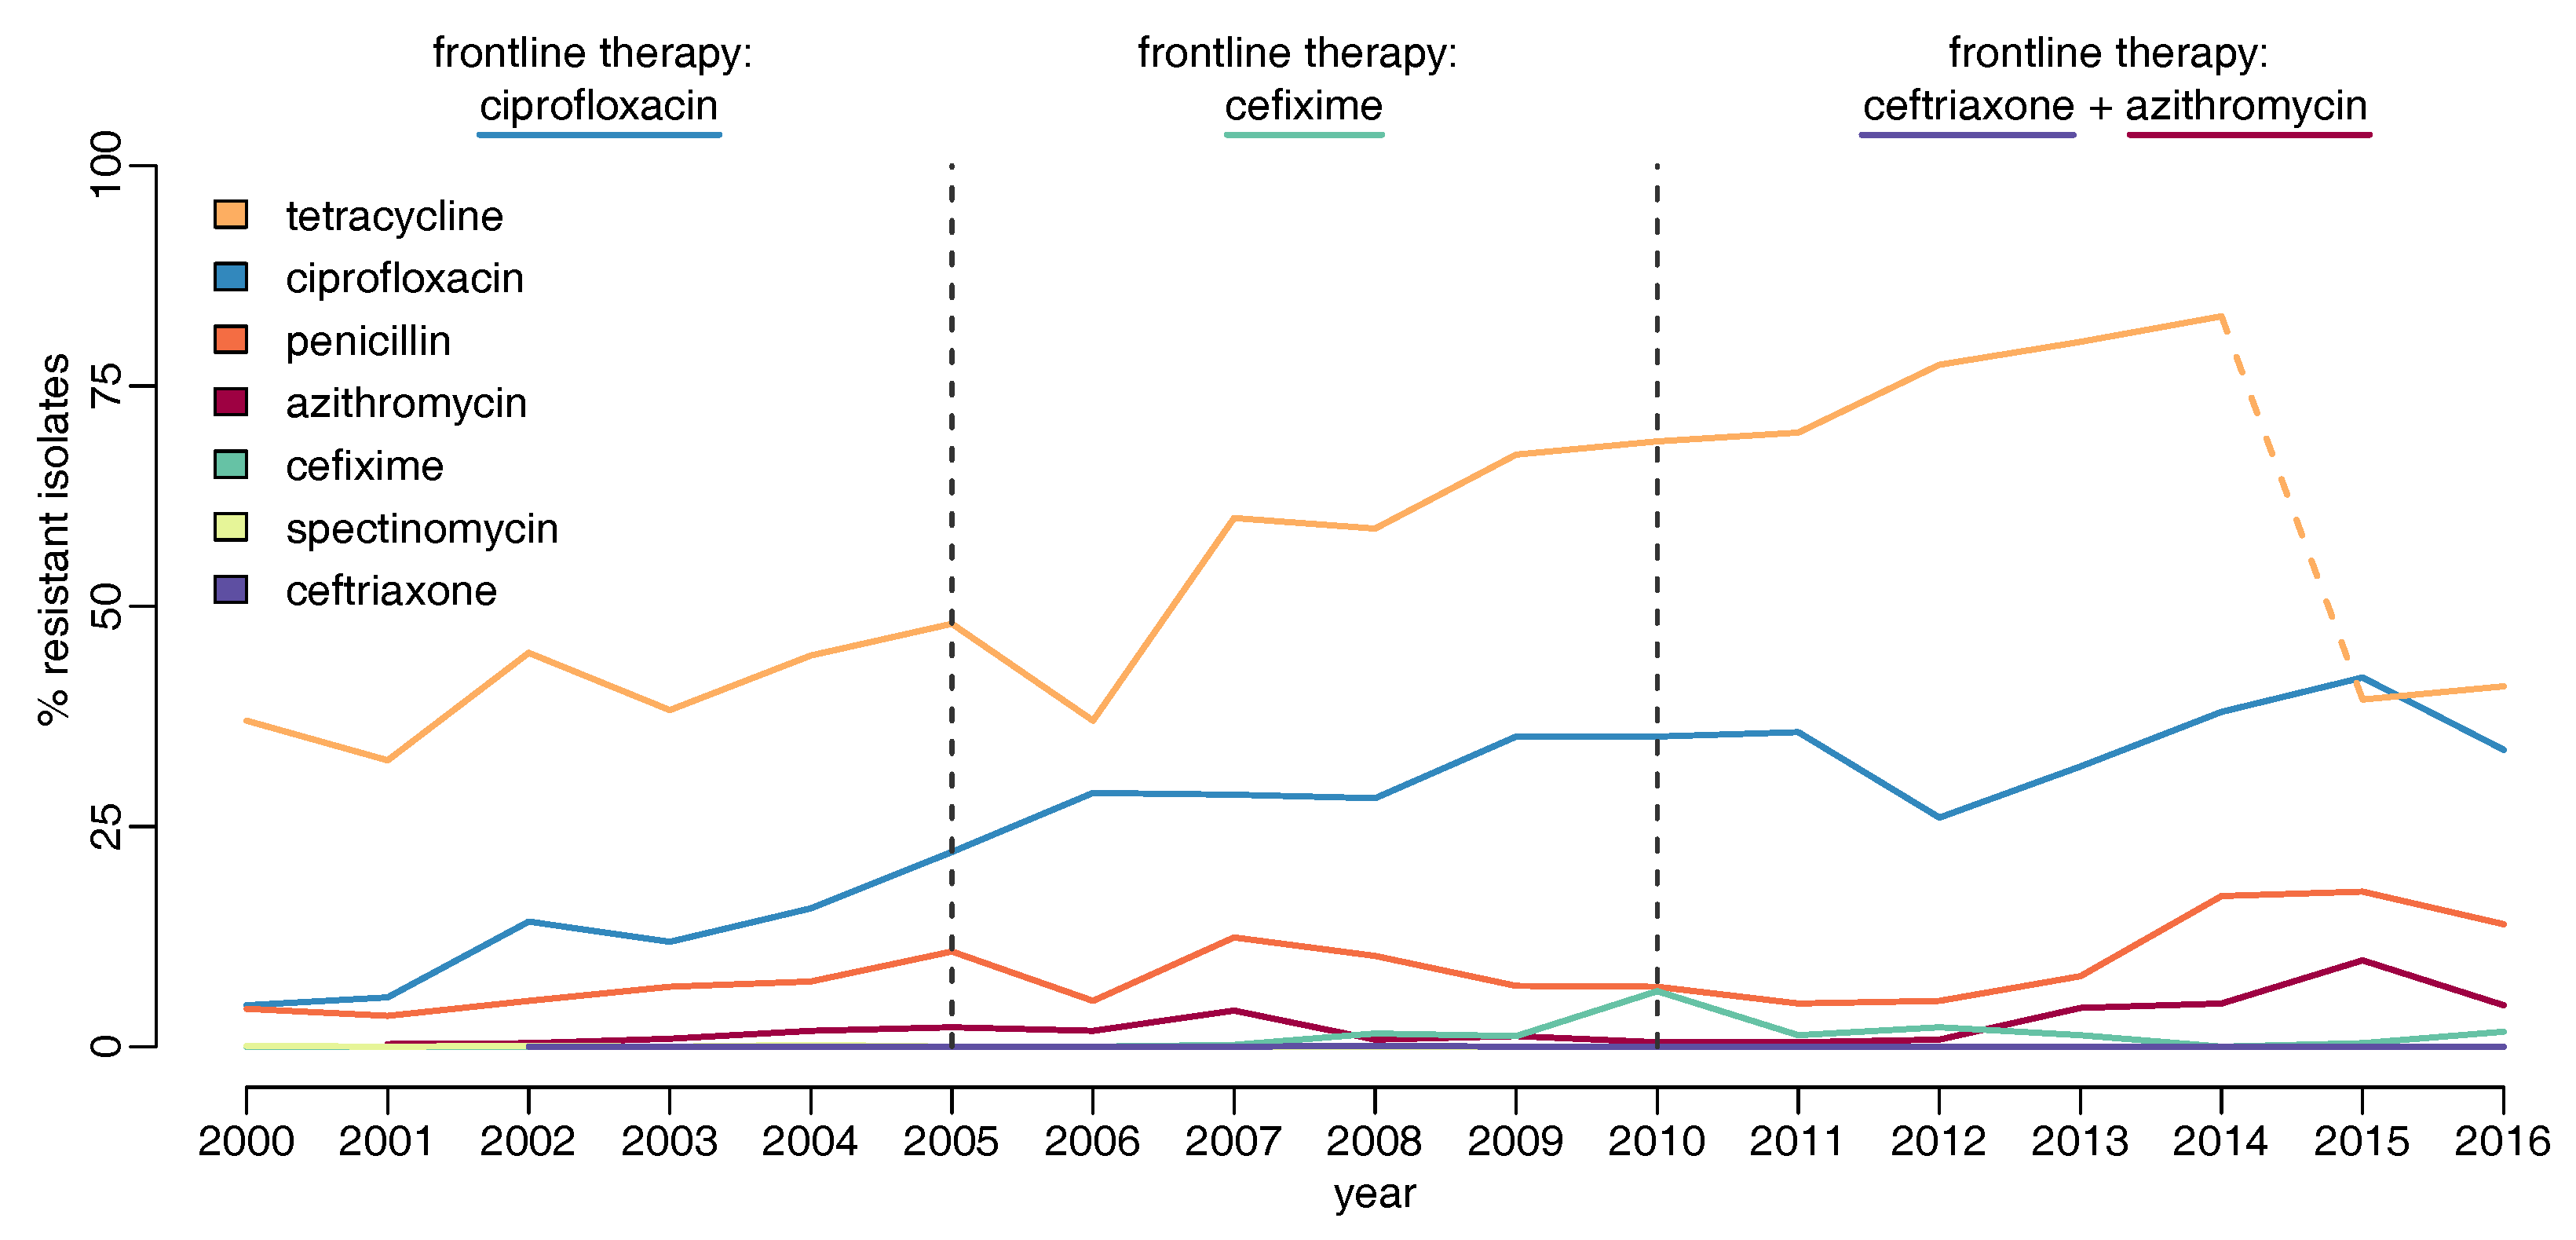

To identify genes involved in resistance the authors have developed a library of unitigs using a technique known as GWAS. Genome-wide association studies (GWAS) help explore the genetic bases of phenotype variation in a population. To circumvent issues involved in conventional genotyping approaches and make bacterial genomes amenable to GWAS, recent studies have relied on k-mers: all nucleotide substrings of length k found in the genomes. Since  SNP- and gene-based representations lack the right level of flexibility to cover complete genomic variation, and, on the other hand, k-mer-based representations which are flexible but not readily interpretable therefore DBG-GWAS De Bruijn Graph GWAS was used. These graphs connect overlapping k-mers (here DNA fragments), yielding a compact summary of all variations across a set of genomes. DBGs accommodate more complex disparities including rearrangements and insertions/deletions.
(Jaillard M, Lima L, Tournoud M, Mahé P, van Belkum A, Lacroix V, et al. (2018) A fast and agnostic method for bacterial genome-wide association studies: Bridging the gap between k-mers and genetic events. PLoS Genet 14(11): e1007758. https://doi.org/10.1371/journal.pgen.1007758)

The goal of this study is to identify the unitigs that are most likely to contribute to a resistance phenotype in our samples.

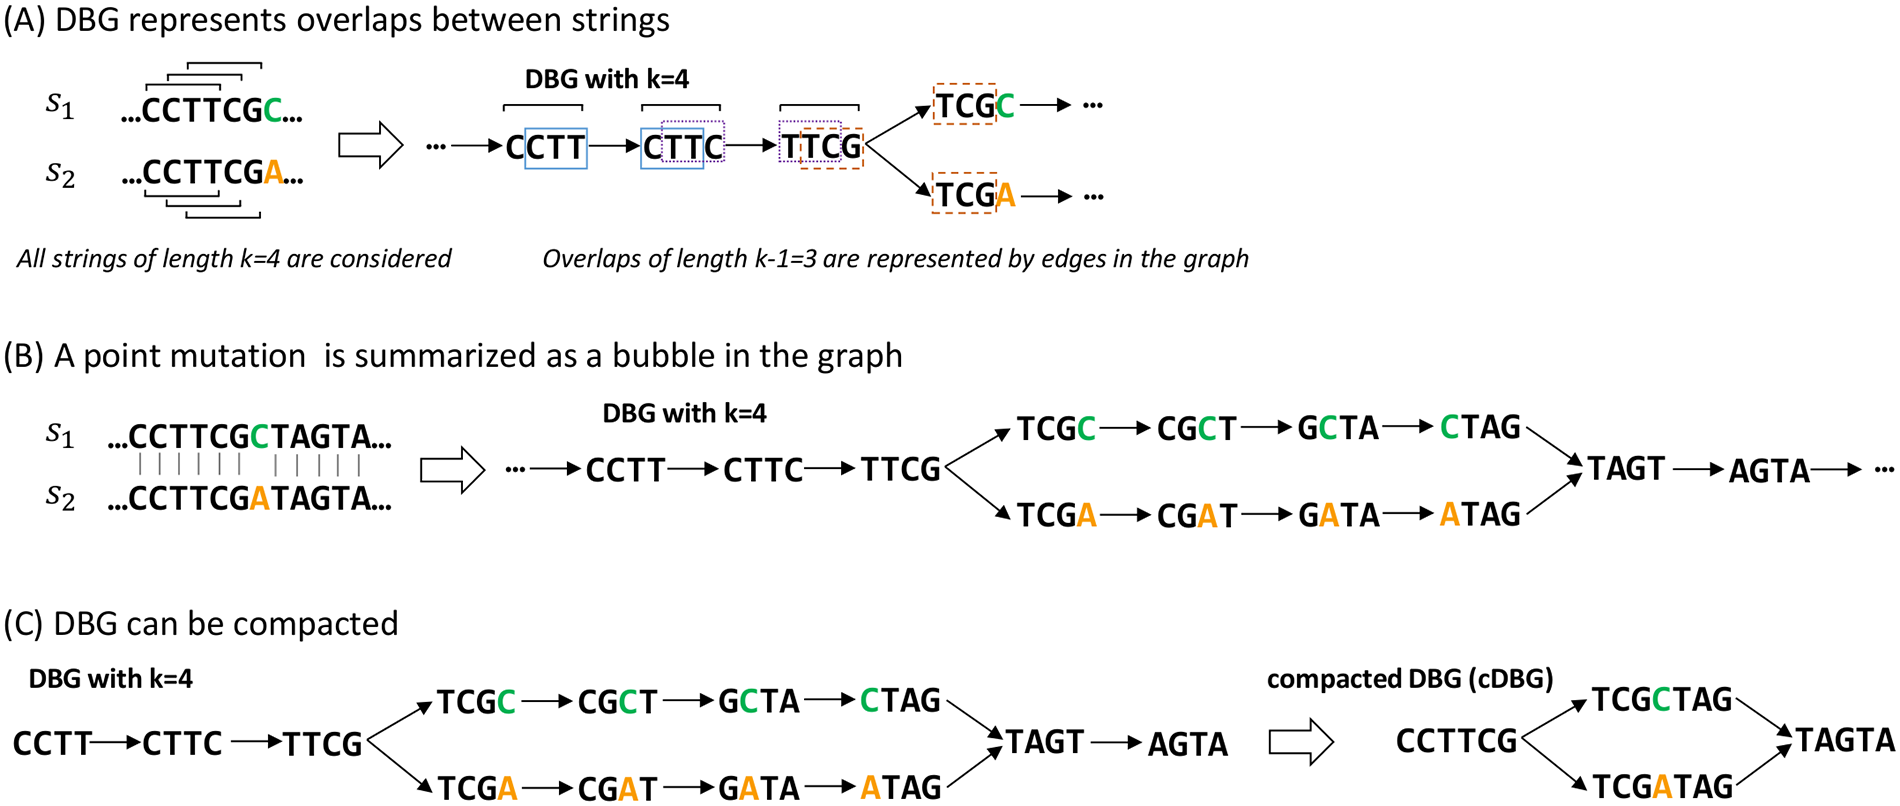

## 1) Import all Libraries

In [ ]:
#import all the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold # Allows for Cross vallidation studies
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV # Library allows for finding out best hyperparameters for each model
from sklearn.svm import SVC #
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sb
import time

## 2) Data Preprocessing

Create a database which contains 3 columns - Sample ID, Unitig_probability_of_occurance and resistance/sensitivity state. Presence of unitif is marked with a 1 and absense with 0. Resistance trait is marked with 1 and sensitivity 0. Final dataset should have only those IDs that have a value corresponding to the resistance profile.

In [ ]:
# Function for preparing our data to merge the probability of occurance of each unitig and its corresponding resistance in each bacteria sample
def prep_data(phenotype) :
    pheno = pd.read_csv('metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=['azm_sr']) # drop samples that don't have a value for our chosen resistance profile
    pheno = pheno['azm_sr']
        
    # read in unitig data
    X = pd.read_csv('azm_sr_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose() # Convert rows to columns
    print(X)
    X = X[X.index.isin(pheno.index)] # only keep rows with a resistance value
    print(pheno)
    return X, pheno

X = []
X, pheno = prep_data(phenotype)

pattern_id  CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG  ...  TTTTGAGCAGAAAGCAGTCAAAAACAGGGGGATTTTGCCCTTTTGACAGGTTCGAGTGCCG
ERR1549286                                                0  ...                                                  1            
ERR1549290                                                0  ...                                                  1            
ERR1549291                                                0  ...                                                  1            
ERR1549287                                                0  ...                                                  1            
ERR1549288                                                0  ...                                                  1            
...                                                     ...  ...                                                ...            
ERR2172350                                                0  ...                                        

### 3) Identifying best classification model with best hyperparameters.

In [ ]:
results = [] # Initialising various lists to store performance metrics
performance = []
method = []
times = []

# function for fitting a model
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    kfold = KFold(n_splits=5) # Performing Cross validaion using Kfold cross vallidation technique

    for train_index, test_index in kfold.split(X, pheno):# Returns indices of the split training ad test data
        
        start = time.process_time() # time how long it takes to train each model type
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # GridSearch Cross Validation builds multiple models using different combinations of hyperparameters and sees which combination performs the best.
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        # cv mentions number of cross validations the model will perform with each set of hyperparameters, n_jobs is assigned to use all available processors
        
        gs_clf.fit(X_train, y_train) #fit each training and test set
        y_pred = gs_clf.predict(X_test)# predict resistance in test set
        
        y_pred[y_pred<0.5] = 0 #assign binary values to non binary predictions
        y_pred[y_pred>0.5] = 1
        results= np.append (y_pred, y_test) #store results for comparison

        score = balanced_accuracy_score(y_test, y_pred) # Measure balanced accuracy scores
        performance = np.append(performance, score)
        method = np.append(method, modelname)# Store the performance, method and times
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
    return gs_clf, method, performance, times, results

##4) Identify accuracy and hyperparameters on SVM model

In [ ]:
svm = SVC(class_weight='balanced')

# C - soft margin constant accounts for margin errors, gamma and kernels allows for better fitting and curvature
svm_params = {'C': [0.01, 0.1], 'gamma': [1e-07, 1e-06, 1e-05], 'kernel': ['rbf','linear']}

svm_model, method, performance, times, results = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

Best hyperparameters for this fold
{'C': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-07, 'kernel': 'linear'}
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-07, 'kernel': 'linear'}
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-07, 'kernel': 'linear'}
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-07, 'kernel': 'linear'}


##5) Identify accuracy and hyperparameters on Random Forest Classification model

In [ ]:
rf = RandomForestClassifier(random_state=0,)

# max_features: max number of features considered for splitting a node, n_estimators = number of trees in the foreset, max_depth: max number of levels in each decision tree

rf_params = {'max_features': [100, 200, 400], 'max_depth': [5,10], 'n_estimators': [50, 100, 150]}
rf_model, method, performance, times, results = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)

Best hyperparameters for this fold
{'max_depth': 10, 'max_features': 200, 'n_estimators': 100}
Best hyperparameters for this fold
{'max_depth': 5, 'max_features': 400, 'n_estimators': 150}
Best hyperparameters for this fold
{'max_depth': 5, 'max_features': 200, 'n_estimators': 100}
Best hyperparameters for this fold
{'max_depth': 5, 'max_features': 400, 'n_estimators': 50}
Best hyperparameters for this fold
{'max_depth': 5, 'max_features': 200, 'n_estimators': 150}


##5) Identify accuracy and hyperparameters on K-Nearest Neighbours Classification model

In [ ]:
kn = KNeighborsClassifier()
# Check for n_neighbour values 2, 5, 7, 10; weights discribe the influence of the K_nearest neighbours on the newest points.
kn_params = {'n_neighbors' : [2, 5, 7, 10], 'weights': ['uniform', 'distance']}

kn_model, method, performance, times, results = fitmodel(X, pheno, kn, kn_params, "KNN Classifier", method, performance, times)

Best hyperparameters for this fold
{'n_neighbors': 2, 'weights': 'distance'}
Best hyperparameters for this fold
{'n_neighbors': 2, 'weights': 'distance'}
Best hyperparameters for this fold
{'n_neighbors': 5, 'weights': 'distance'}
Best hyperparameters for this fold
{'n_neighbors': 5, 'weights': 'distance'}
Best hyperparameters for this fold
{'n_neighbors': 7, 'weights': 'distance'}


# Comparing Accuracy of the models

The accuracy scores for each fold is plotted (5 fold total) for all three models and compared.
Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics. sb.set_context sets the parameters that control the scaling of plot elements. swarmplot method allows for plotting of a scatter plot that adjusts the positions of the points along the categorical axis so that they don’t overlap.
SVM and Random Forest classification seem to provide high accuracy with lower chances of overfitting.

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

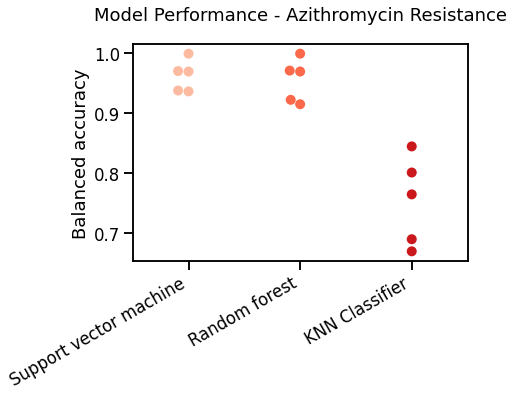

In [ ]:
sb.set_context('talk')
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance, palette="Reds", size=10)
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha='right')# Arranges the terms on the X axis at 30deg angle to prevent them from overlapping

# Comparing Computation Time of the models

Similarly the time taken for executing each fold in 5 fold cross validation is plotted for each model. 

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

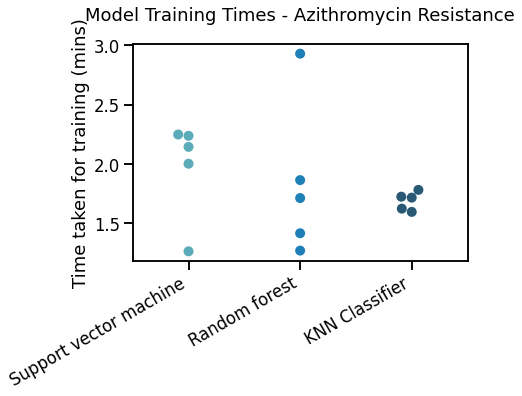

In [ ]:
sb.set_context("talk")
plt.title("Model Training Times - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)
plt.ylabel("Time taken for training (mins)")
plt.xticks(rotation=30, ha='right')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, pheno, test_size = 0.25, random_state = 0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators=100, max_depth = 5, max_features = 200, criterion='entropy', random_state = 0)
RFclassifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features=200,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = RFclassifier.predict(X_test)

[[744   9]
 [  5 112]]
0.9726563830149488


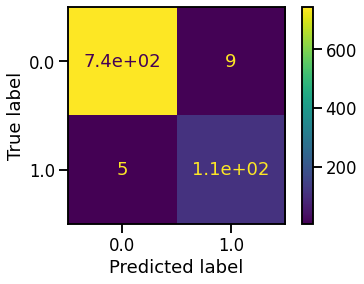

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=RFclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=RFclassifier.classes_)
disp.plot() 
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(balanced_accuracy_score(y_test, y_pred))

## Predicting the unitigs most likely involved in resistance

The following snippet helps us identify which unitig is the biggest contributer to resistance by comparing all unitigs.
Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation. After being fit, the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature.


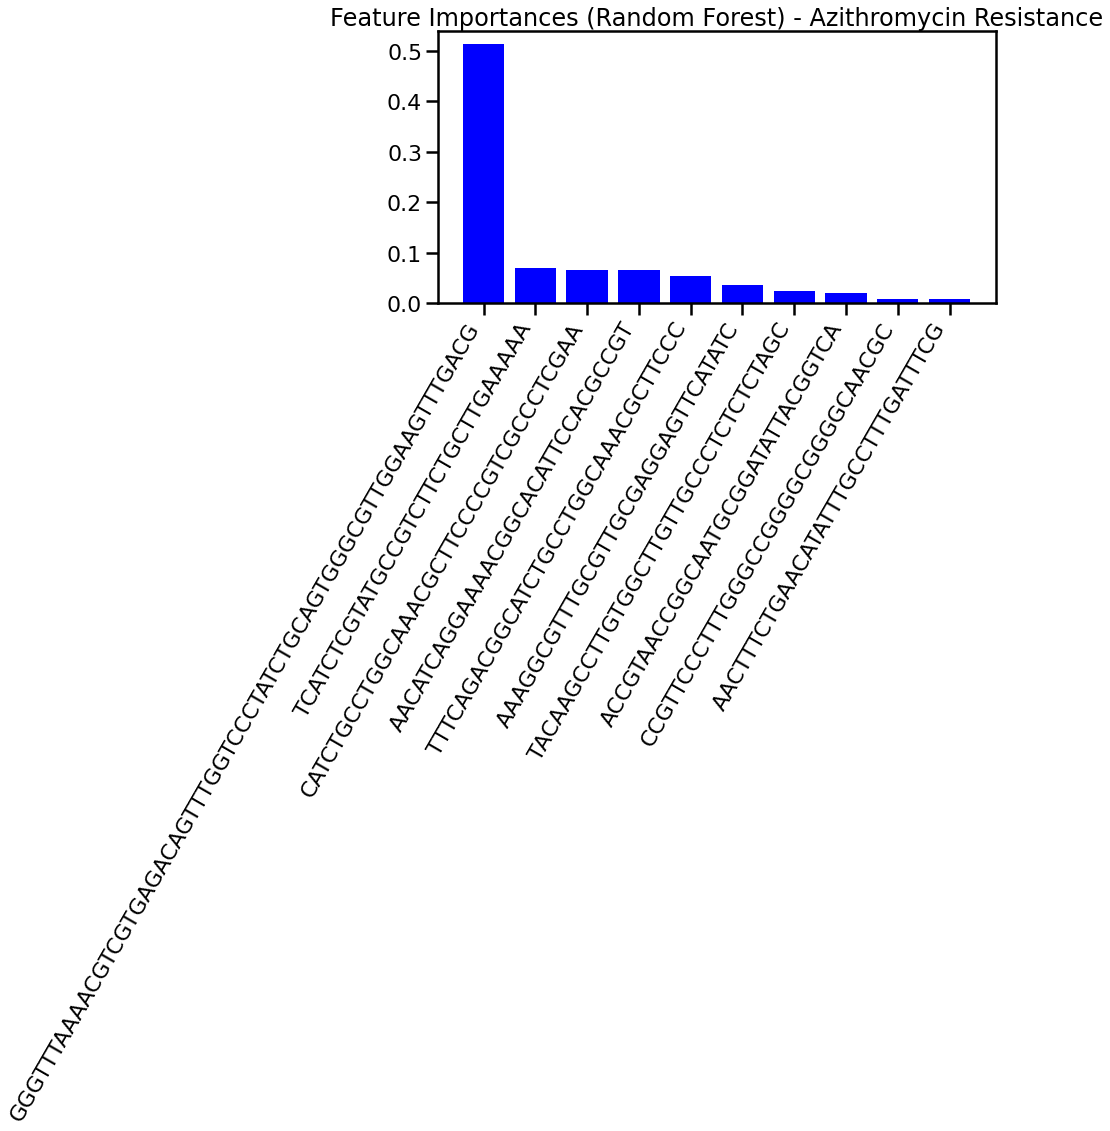

Top predictors:  ['GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG'
 'TCATCTCGTATGCCGTCTTCTGCTTGAAAAA' 'CATCTGCCTGGCAAACGCTTCCCCGTCGCCCTCGAA'
 'AACATCAGGAAAACGGCACATTCCACGCCGT' 'TTTCAGACGGCATCTGCCTGGCAAACGCTTCCC'
 'AAAGGCGTTTGCGTTGCGAGGAGTTCATATC' 'TACAAGCCTTGTGGCTTGTTGCCCTCTCTCTAGC'
 'ACCGTAACCGGCAATGCGGATATTACGGTCA' 'CCGTTCCCTTTGGGCCGGGGCGGGGCAACGC'
 'AACTTTCTGAACATATTTGCCTTTGATTTCG']


In [ ]:
importances = RFclassifier.feature_importances_
indices = np.argsort(importances)[::-1][:10] #Sorting function that sorts all the unitigs and returns indices of top 10 unitigs
feature_names = list(X.columns) # List of all column names
# Plot the feature importances of the forest
sb.set_context("poster")
plt.figure(figsize=(10, 5))
plt.title("Feature Importances (Random Forest) - Azithromycin Resistance")
plt.bar(range(10), importances[indices],
       color="blue", align="center")
plt.xticks(range(10), np.asarray(feature_names)[indices], rotation=60, ha='right')
plt.show()

print("Top predictors: ", np.asarray(feature_names)[indices])